In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import datetime                   # library for date manipulation

from sklearn.decomposition import PCA
from scipy.stats import norm, rankdata
from scipy.interpolate import interp1d

from os import path, makedirs

import sys
sys.path.append("../src/confer_wp3/")
from plotting import plot_fields                                    # function for visualizing spatial data in a map
from lasso_forecast import calculate_tercile_probability_forecasts

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loading, and save out.

### Testing

In [4]:
# Predictors: uwind200, uwind850, sst, chirps
# Dir: era5_dir or chirps_dir
    
def load_raw_data(dir, predictor, bounding_box, years, season=None):
    # Construct file path
    if predictor == "sst":
        pth = "sst/full.nc"
    elif predictor == "uwind200":
        pth = "uwind/200hpa/full.nc"
    elif predictor == "uwind850":
        pth = "uwind/850hpa/full.nc"
    elif predictor == "chirps":
        pth = "prec_raw.nc"
    file_path = f"{dir}{pth}"
    
     # Load data
    data = xr.open_dataset(file_path)
    print("Original data shape:", data['prec'].shape)
    print("NaN values in original data:", np.isnan(data['prec']).sum())
    
    # Subset data based on bounding box
    lon_min, lon_max, lat_min, lat_max = bounding_box
    data = data.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    print("Data shape after subsetting by bounding box:", data['prec'].shape)
    print("NaN values after subsetting by bounding box:", np.isnan(data['prec']).sum())
    
    # Subset data based on years
    data = data.sel(year=slice(years[0], years[-1]))
    print("Data shape after subsetting by years:", data['prec'].shape)
    print("NaN values after subsetting by years:", np.isnan(data['prec']).sum())
    
    # Aggregate by season if provided
    if predictor == "chirps" and season is not None:
        if season == 'OND':
            season_months = [10, 11, 12]
        elif season == 'MAM':
            season_months = [3, 4, 5]
        elif season == 'JJAS':
            season_months = [6, 7, 8, 9]
        data = data.sel(month=np.isin(data['month'], season_months))
        print("Data shape after subsetting by season:", data['prec'].shape)
        print("NaN values after subsetting by season:", np.isnan(data['prec']).sum())
        
        # Convert to NumPy array for easier manipulation
        data_np = data['prec'].values
        
        # Check for mixed NaN and non-NaN values
        mixed_nan_mask = np.any(np.isnan(data_np), axis=0) & ~np.all(np.isnan(data_np), axis=0)
        mixed_nan_count = np.sum(mixed_nan_mask)
        print(f"Number of grid points with mixed NaN and non-NaN values: {mixed_nan_count}")
        
        
        if mixed_nan_count > 0:
            raise ValueError("Found grid points with mixed NaN and non-NaN values.")
        
        # Aggregate by summing over the selected months
        data = data.groupby('year').sum(dim='month', skipna=False)
        print("Data shape after aggregating by season:", data['prec'].shape)
        print("NaN values after aggregating by season:", np.isnan(data['prec']).sum())
    
    # Convert to NumPy arrays
    year = data['year'].values
    lon = data['lon'].values
    lat = data['lat'].values

    if predictor == "chirps":
        predictor_values = data['prec'].values # Shape: (year, lat, lon)
    elif predictor == "uwind200" or predictor == "uwind850":
        predictor_values = data['uwind'].values
    elif predictor == "sst":
        predictor_values = data['sst'].values
    
    return year, lon, lat, predictor_values

#### Loading tests

In [5]:
sst_data_test = xr.open_dataset(f"{era5_dir}/sst/full.nc")
sst_data_test

<xarray.Dataset>
Dimensions:  (year: 71, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1950 1951 1952 1953 1954 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [6]:
uwind_200hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/200hpa/full.nc")
uwind_200hpa_data_test

<xarray.Dataset>
Dimensions:  (year: 74, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022 2023
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [7]:
uwind_850hpa_data_test = xr.open_dataset(f"{era5_dir}/uwind/850hpa/full.nc")
uwind_850hpa_data_test

<xarray.Dataset>
Dimensions:  (year: 74, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2019 2020 2021 2022 2023
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

### CHIRPS DATA

Raw CHIRPS data:  
(year, month, lon, lat, prec)  
year 1981 - 2023   
month 1-12  
lat -11.5 to 21.5  
lon 22.0 to 51.0  
one prec value for each combination of the four above  

##### Loading data

In [8]:
# TESTING
test_dir = "/nr/samba/user/ahellevik/CONFER-WP3/testdata/"

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
year, lon, lat, prec_data = load_raw_data(chirps_dir, "chirps", box, [i for i in range(1993, 2021)], season=season)
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Original data shape: (12, 43, 67, 59)
NaN values in original data: <xarray.DataArray 'prec' ()>
array(987076)
Data shape after subsetting by bounding box: (12, 43, 67, 59)
NaN values after subsetting by bounding box: <xarray.DataArray 'prec' ()>
array(987076)
Data shape after subsetting by years: (12, 28, 67, 59)
NaN values after subsetting by years: <xarray.DataArray 'prec' ()>
array(640080)
Data shape after subsetting by season: (3, 28, 67, 59)
NaN values after subsetting by season: <xarray.DataArray 'prec' ()>
array(160020)
Number of grid points with mixed NaN and non-NaN values: 0
Data shape after aggregating by season: (28, 67, 59)
NaN values after aggregating by season: <xarray.DataArray 'prec' ()>
array(53340)
Loaded data shape: (28, 67, 59)
NaN values in loaded data: 53340


##### Calculate anomalies

In [9]:
# Restrict to the geographical bounds
lon_mask = (lon >= lon_bnds[0]) & (lon <= lon_bnds[1])
lat_mask = (lat >= lat_bnds[0]) & (lat <= lat_bnds[1])

lon = lon[lon_mask]
lat = lat[lat_mask]
prec_data = prec_data[:, lat_mask, :][:, :, lon_mask]

# Select the reference period using a boolean mask
ref_period_mask = (year >= year_clm_start) & (year <= year_clm_end)
ref_period_indices = np.where(ref_period_mask)[0]

# Calculate climatology (mean over the reference period)
climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)

# Check if the climatology has NaNs
if np.isnan(climatology).any():
    print("Warning: Climatology contains NaNs")

# Calculate anomalies by subtracting climatology
anomalies = prec_data - climatology[np.newaxis, :, :]

print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in climatology:", np.isnan(climatology).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(28, 67, 59)
(28, 67, 59)
NaN values in prec_data: 53340
NaN values in climatology: 1905
NaN values in anomalies: 53340


/tmp/ipykernel_1681293/1368245306.py:14: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)


##### Visualize calculation of anomalies for a random month/year pair

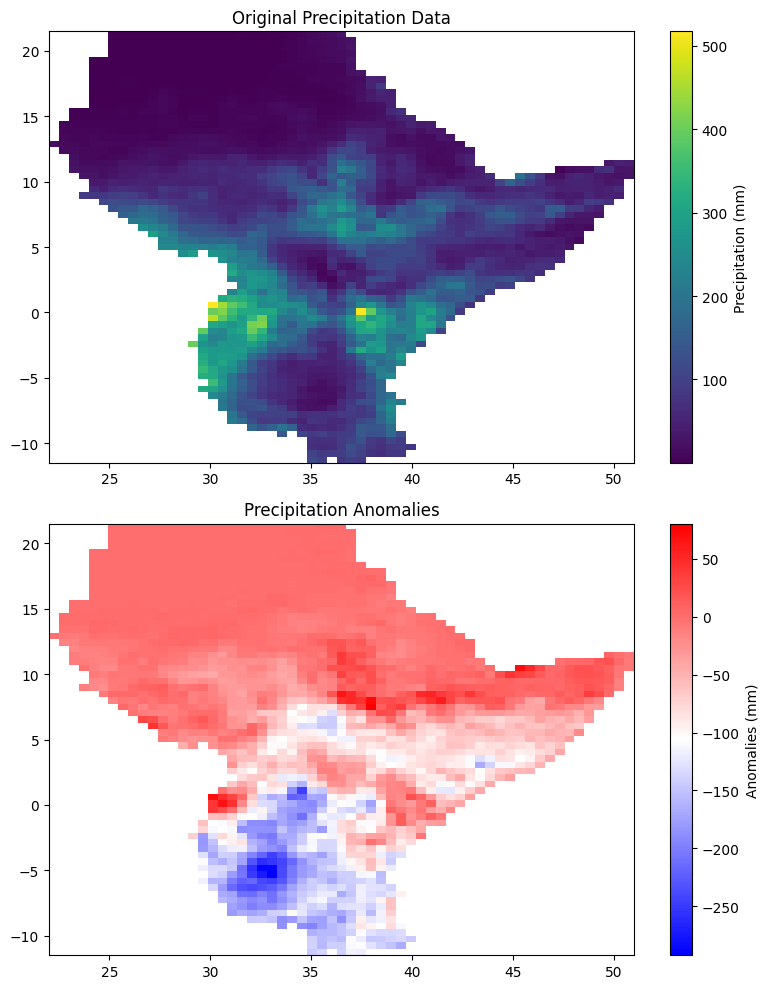

In [10]:
# Plot original precipitation data
plt.figure(figsize=(8, 10))  # Adjusting figsize for a more even aspect ratio
plt.subplot(2, 1, 1)
plt.title('Original Precipitation Data')
plt.imshow(prec_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')

# Plot anomalies
plt.subplot(2, 1, 2)
plt.title('Precipitation Anomalies')
plt.imshow(anomalies[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Anomalies (mm)')
plt.tight_layout()
plt.show()

##### Transform anomalies to normal dist. using quantile mapping

In [11]:
def quantile_mapping(data, ref_indices):
    transformed_data = np.full_like(data, np.nan)
    
    # Standard deviation for the reference period at each grid point
    ref_period_std = np.nanstd(data[ref_indices, :, :], axis=0)
    
    for lat_idx in range(data.shape[1]):
        for lon_idx in range(data.shape[2]):
            ref_data = data[ref_indices, lat_idx, lon_idx]
            ref_data_valid = ref_data[~np.isnan(ref_data)]
            
            if ref_data_valid.size == 0:
                continue
            
            # Add small noise to avoid identical ranks
            ref_data_valid += np.random.normal(0, 1e-10, ref_data_valid.shape)

            # Sort the reference data and calculate percentiles
            sorted_ref_data = np.sort(ref_data_valid)
            # Add small jitter to avoid repeated values
            jitter = np.random.normal(0, 1e-10, sorted_ref_data.shape)
            sorted_ref_data_jittered = sorted_ref_data + jitter
            n = ref_data_valid.size
            ref_percentiles = np.arange(1, n + 1) / (n + 1)
            
            # Calculate the normal scores for the percentiles
            ref_normal = norm.ppf(ref_percentiles)

            # Interpolator for reference period quantiles
            interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', fill_value=(ref_normal[0], ref_normal[-1]), bounds_error=False)
            #interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', fill_value="extrapolate", bounds_error=False)
            
            all_years_data = data[:, lat_idx, lon_idx]
            valid_mask = ~np.isnan(all_years_data) 
            all_years_data_valid = all_years_data[valid_mask]
            
            if all_years_data_valid.size == 0:
                continue
            
            # Interpolation of normal quantiles using reference period
            all_years_normal = interp_func(all_years_data_valid)

            # Standardize the normal values using the reference period standard deviation
            all_years_normal_standardized = all_years_normal * ref_period_std[lat_idx, lon_idx]
            
            # Place standardized values back in the original array shape
            transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal_standardized
            #transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal
            # Check for any new NaNs introduced
            if np.isnan(transformed_data[:, lat_idx, lon_idx]).sum() > np.isnan(data[:, lat_idx, lon_idx]).sum():
                print(f"New NaNs introduced at grid point (lat: {lat_idx}, lon: {lon_idx})")
                print(f"Original NaNs: {np.isnan(data[:, lat_idx, lon_idx]).sum()}")
                print(f"Transformed NaNs: {np.isnan(transformed_data[:, lat_idx, lon_idx]).sum()}")
                print(f"ref_data_valid: {ref_data_valid}")
                print(f"sorted_ref_data: {sorted_ref_data}")
                print(f"ref_percentiles: {ref_percentiles}")
                print(f"ref_normal: {ref_normal}")
                print(f"all_years_data_valid: {all_years_data_valid}")
                print(f"all_years_normal: {all_years_normal}")
                print(f"all_years_normal_standardized: {all_years_normal_standardized}")
            
    return transformed_data

In [12]:
# Apply the transformation to the anomalies data
anomalies_normal = quantile_mapping(anomalies, ref_period_indices)

/nr/samba/user/ahellevik/CONFER-WP3/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
# Saving, if wanted

# Convert to xarray DataArray for saving as NetCDF
anomalies_xr = xr.DataArray(anomalies, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])
anomalies_normal_xr = xr.DataArray(anomalies_normal, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])

# Save the anomalies and transformed anomalies
anomalies_xr.to_netcdf(f"{test_dir}/chirps_anomalies.nc")
anomalies_normal_xr.to_netcdf(f"{test_dir}/chirps_anomalies_normal.nc")

##### Plots to ensure processing anomalies went well

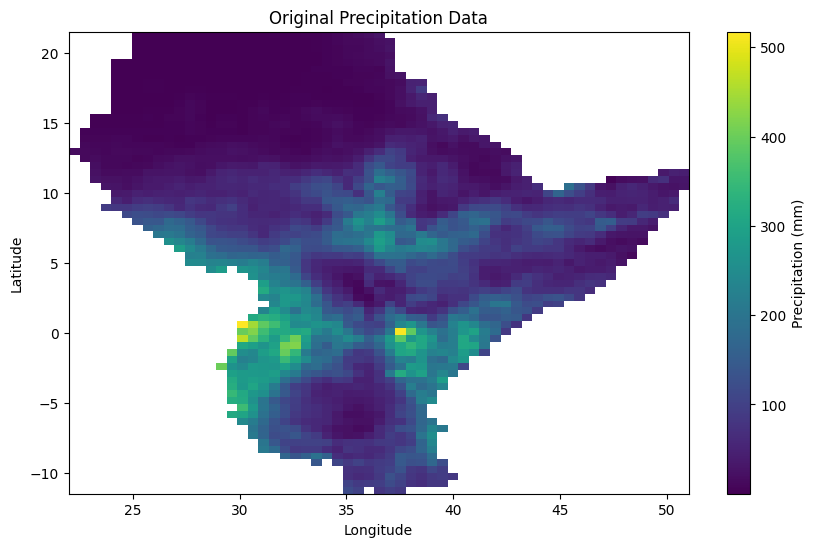

In [14]:
selected_year = 0  # First year in the dataset

plt.figure(figsize=(10, 6))
plt.title('Original Precipitation Data')
plt.imshow(prec_data[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

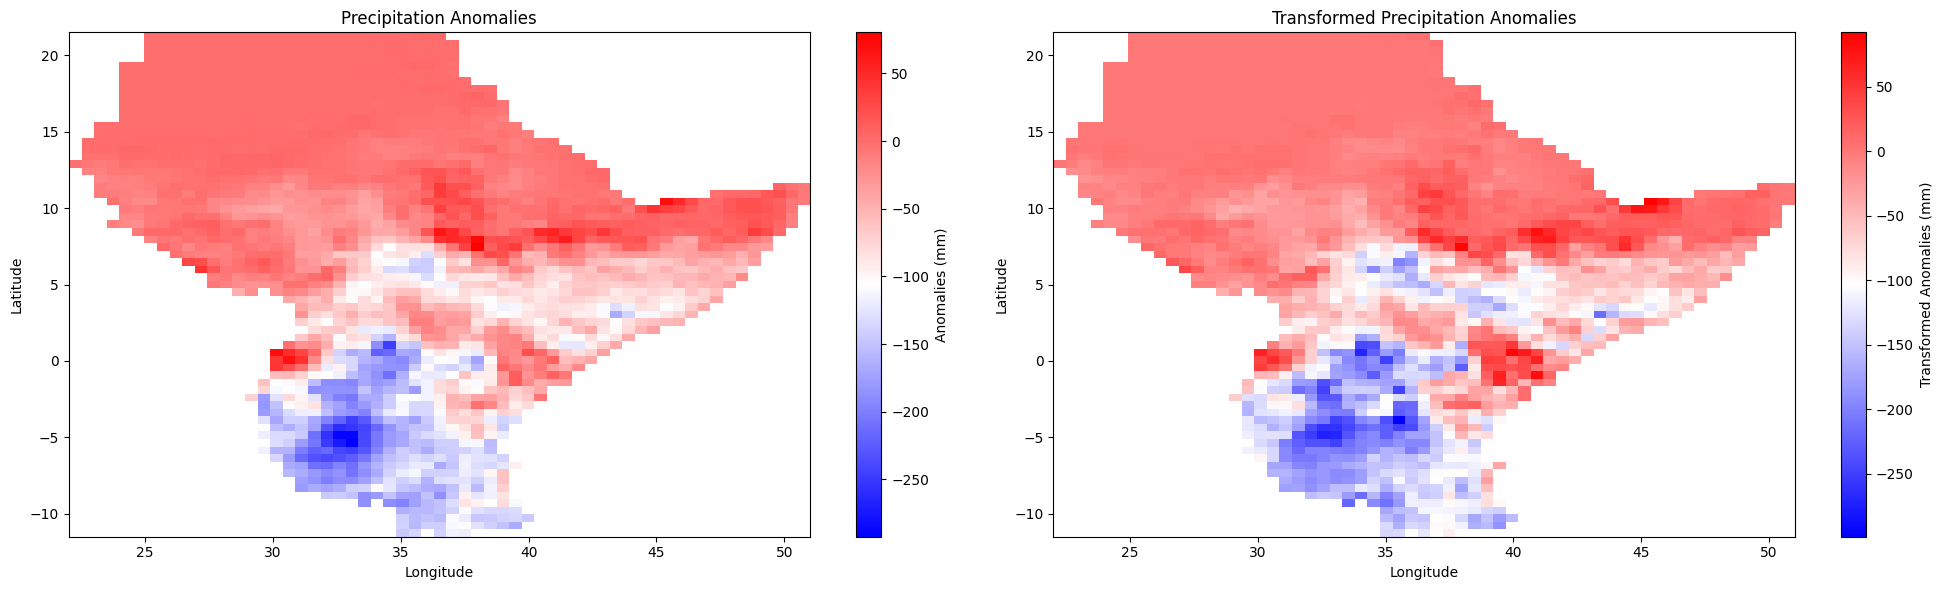

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot Precipitation Anomalies
axes[0].set_title('Precipitation Anomalies')
img1 = axes[0].imshow(anomalies[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto')
fig.colorbar(img1, ax=axes[0], label='Anomalies (mm)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot Transformed Precipitation Anomalies
axes[1].set_title('Transformed Precipitation Anomalies')
img2 = axes[1].imshow(anomalies_normal[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto')
fig.colorbar(img2, ax=axes[1], label='Transformed Anomalies (mm)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


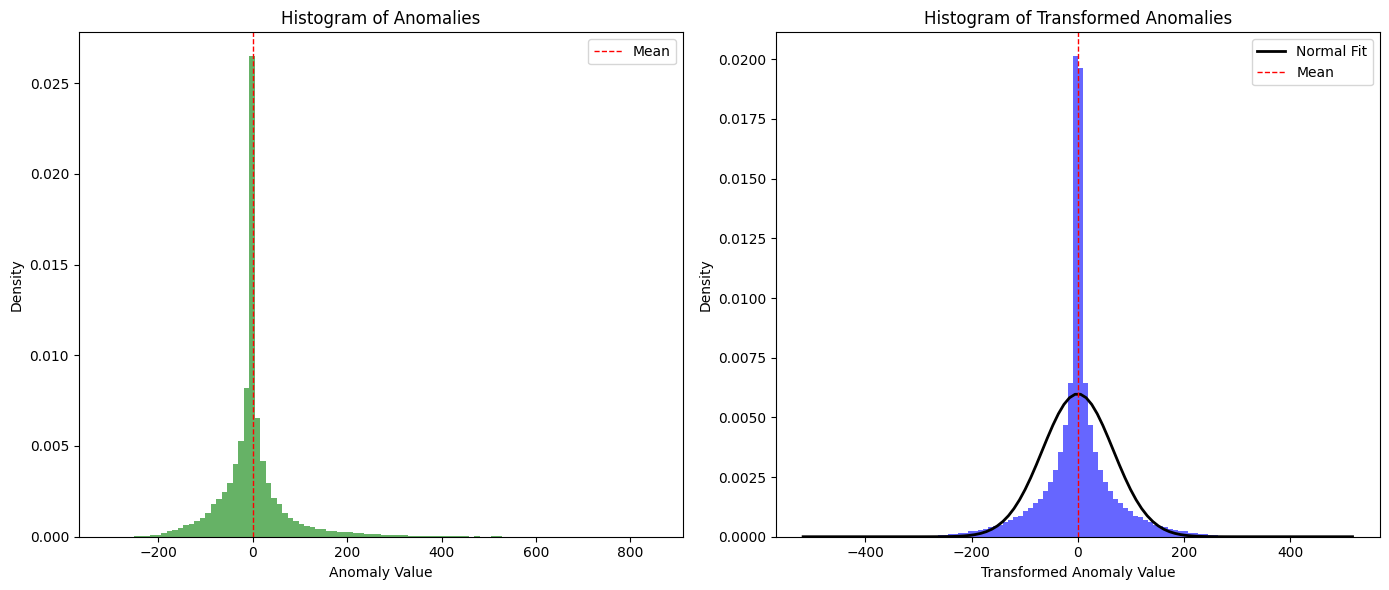

In [16]:
# Flatten the arrays and filter out non-finite values
anomalies_flat = anomalies.flatten()
anomalies_normal_flat = anomalies_normal.flatten()

# Remove non-finite values
anomalies_flat = anomalies_flat[np.isfinite(anomalies_flat)]
anomalies_normal_flat = anomalies_normal_flat[np.isfinite(anomalies_normal_flat)]

plt.figure(figsize=(14, 6))

# Original anomalies histogram
plt.subplot(1, 2, 1)
plt.hist(anomalies_flat, bins=100, density=True, alpha=0.6, color='g')
plt.title('Histogram of Anomalies')
plt.xlabel('Anomaly Value')
plt.ylabel('Density')
plt.axvline(np.mean(anomalies_flat), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean'])

# Transformed anomalies histogram
plt.subplot(1, 2, 2)
plt.hist(anomalies_normal_flat, bins=100, density=True, alpha=0.6, color='b')

# Overlay normal distribution curve
mu, std = norm.fit(anomalies_normal_flat)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of Transformed Anomalies')
plt.xlabel('Transformed Anomaly Value')
plt.ylabel('Density')
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
plt.legend(['Normal Fit', 'Mean'])

plt.tight_layout()
plt.show()

In [17]:
print("Anomalies - mean:", np.nanmean(anomalies), "std:", np.nanstd(anomalies))
print("Transformed Anomalies - mean:", np.nanmean(anomalies_normal), "std:", np.nanstd(anomalies_normal))

# Check for any inf values
print("Inf values in anomalies:", np.isinf(anomalies).sum())
print("Inf values in transformed anomalies:", np.isinf(anomalies_normal).sum())

# Check for any nan values
print("NaN values in anomalies:", np.isnan(anomalies).sum())
print("NaN values in transformed anomalies:", np.isnan(anomalies_normal).sum())


Anomalies - mean: 1.0560533e-07 std: 74.32948
Transformed Anomalies - mean: 0.00013308387 std: 66.662735
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 53340
NaN values in transformed anomalies: 53340


##### Calculate EOFs

In [18]:
from eofs.standard import Eof

In [19]:
# Mask NaNs in the arrays
anomalies_masked = np.ma.masked_invalid(anomalies)
normalized_anomalies_masked = np.ma.masked_invalid(anomalies_normal)

# Reshape the data to 2D (time, space) for EOF computation
year, lat, lon = anomalies_masked.shape
anomalies_reshaped = anomalies_masked.reshape(year, lat * lon)
normalized_anomalies_reshaped = normalized_anomalies_masked.reshape(year, lat * lon)

# Initialize the EOF solver
solver_anomalies = Eof(anomalies_reshaped)
solver_norm_anomalies = Eof(normalized_anomalies_reshaped)

# Calculate the EOFs and PCs
eofs_anomalies = solver_anomalies.eofs(neofs=2)
pcs_anomalies = solver_anomalies.pcs(npcs=2)

eofs_norm_anomalies = solver_norm_anomalies.eofs(neofs=2)
pcs_norm_anomalies = solver_norm_anomalies.pcs(npcs=2)

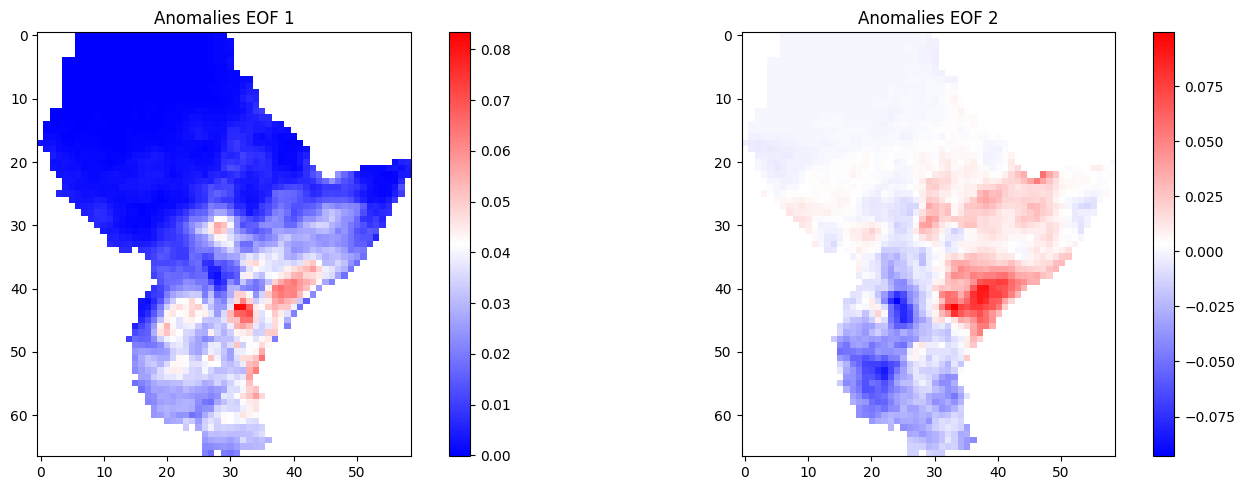

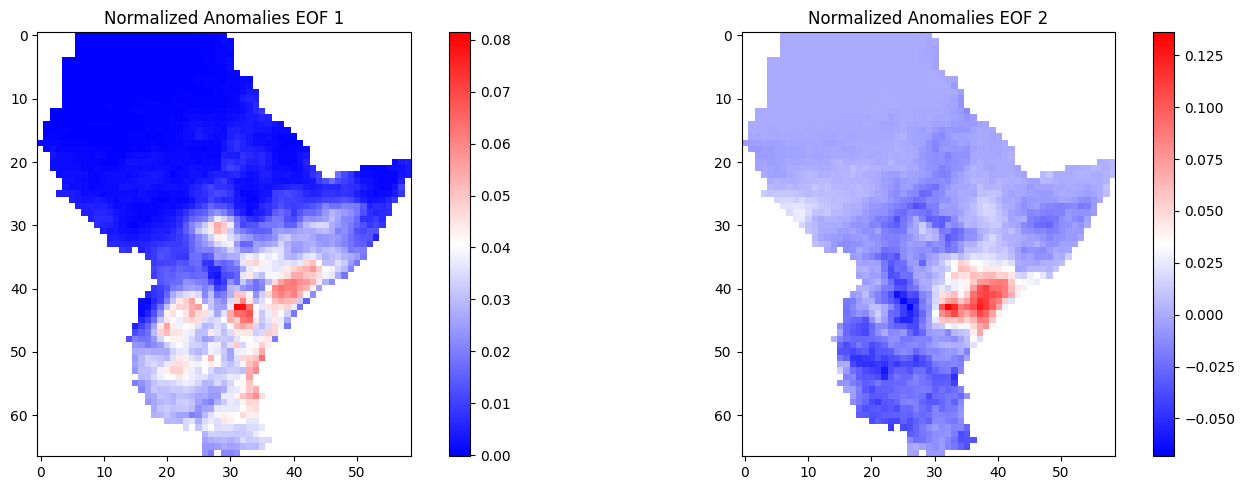

In [20]:
# Reshape the EOFs back to the original spatial dimensions
eofs_anomalies_reshaped = eofs_anomalies.reshape(2, lat, lon)
eofs_norm_anomalies_reshaped = eofs_norm_anomalies.reshape(2, lat, lon)

# Plotting function
def plot_eofs(eofs, title, cmap='bwr'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for i in range(2):
        # Flip the EOF arrays vertically
        flipped_eof = np.flipud(eofs[i])
        im = axes[i].imshow(flipped_eof, cmap=cmap, interpolation='none')
        axes[i].set_title(f'{title} EOF {i+1}')
        fig.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

# Plot EOFs for anomalies
plot_eofs(eofs_anomalies_reshaped, 'Anomalies')

# Plot EOFs for normalized anomalies
plot_eofs(eofs_norm_anomalies_reshaped, 'Normalized Anomalies')

In [21]:
#filename_pct_target = f'{percentile_dir}percentiles_{target}_{year_train_start}_{year_train_end}.nc'

#if not path.exists(filename_pct_target):
#    calculate_target_percentiles(target, year_train_start, year_train_end, lon_bnds, lat_bnds, target_dir, filename_pct_target)

data_load = xr.open_dataset(f'{anomaly_dir}refper_{period_clm[0]}-{period_clm[1]}/precip_full_{season}.nc', engine='netcdf4')
lon = data_load.lon.values
lat = data_load.lat.values
data_load.close()

nlon = len(lon)
nlat = len(lat)

If not already available, load ERA5 data, calculate indices, and save out.

In [22]:
# do it

Run LASSO model to predict precipitation EOFs based on indices.

In [23]:
# do it

Visualize fitted coefficients

In [24]:
# do it

Load indices for the forecast year and use the previously fitted model to make a forecast

In [25]:
prob_fcst_below, prob_fcst_above = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_train, period_clm, indices_dir, anomaly_dir, eof_dir, fcst_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/refper_1993-2020/prec_full_seasonal_OND.nc'

Depict as a map.

In [ ]:
plot_fields (fields_list = [prob_fcst_below, prob_fcst_above],
          lon = lon,
          lat = lat,
          lon_bounds = lon_bnds,
          lat_bounds = lat_bnds,
          main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
          subtitle_list = ['below normal','above normal'],
          vmin = 0.333,
          vmax = 1,
          cmap = ['Oranges','Greens'],
          unit = '')